In [1]:
from future.backports.datetime import datetime
%matplotlib inline

import os
import mne
import scipy.io.wavfile as io_wav
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate
import soundfile as sf
import librosa

In [2]:
# Helper functions
def read_wav(filename):
    """Reads a wav file."""
    (Fs, x) = io_wav.read(filename)
    return (x, Fs)

def normalize_signal(signal):
    """Normalize the signal to be in the range of -1 to 1."""
    return signal / np.max(np.abs(signal))

def detect_peaks_in_signal(signal, threshold=0.3, distance=1000):
    """Detect peaks in a normalized signal using a threshold."""
    peaks, _ = find_peaks(signal, height=threshold, distance=distance)
    return peaks

In [3]:
# Directory paths
dir_data = os.path.join('data', '05_experiment_2024_09_06', 'Sztahó Dávid')
uti_path = os.path.join(dir_data, "UTI", 'Export3')
eeg_path = os.path.join(dir_data, "EEG")

In [4]:
# List EEG and sync files
eeg_files = [f for f in sorted(os.listdir(eeg_path)) if f.endswith('.vhdr')]
sync_files_all = [f for f in sorted(os.listdir(uti_path)) if f.endswith('_sync.wav')] # Sync files, that actually we don't use anymore
speech_files_all = [f for f in sorted(os.listdir(uti_path)) if f.endswith('_speech.wav')]


In [5]:
print(speech_files_all)

['File001_speech.wav', 'File002_speech.wav', 'File003_speech.wav', 'File004_speech.wav', 'File005_speech.wav', 'File006_speech.wav', 'File007_speech.wav']


In [6]:
print(eeg_files)

['david_beszed_teszt.vhdr', 'david_beszed_teszt2.vhdr', 'david_beszed_teszt3.vhdr']


In [7]:
# Step 1: Read the first EEG file
eeg_file = eeg_files[2]
raw_eeg = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file), preload=True)

Extracting parameters from data/05_experiment_2024_09_06/Sztahó Dávid/EEG/david_beszed_teszt3.vhdr...
Setting channel info structure...
Reading 0 ... 93059  =      0.000 ...    93.059 secs...


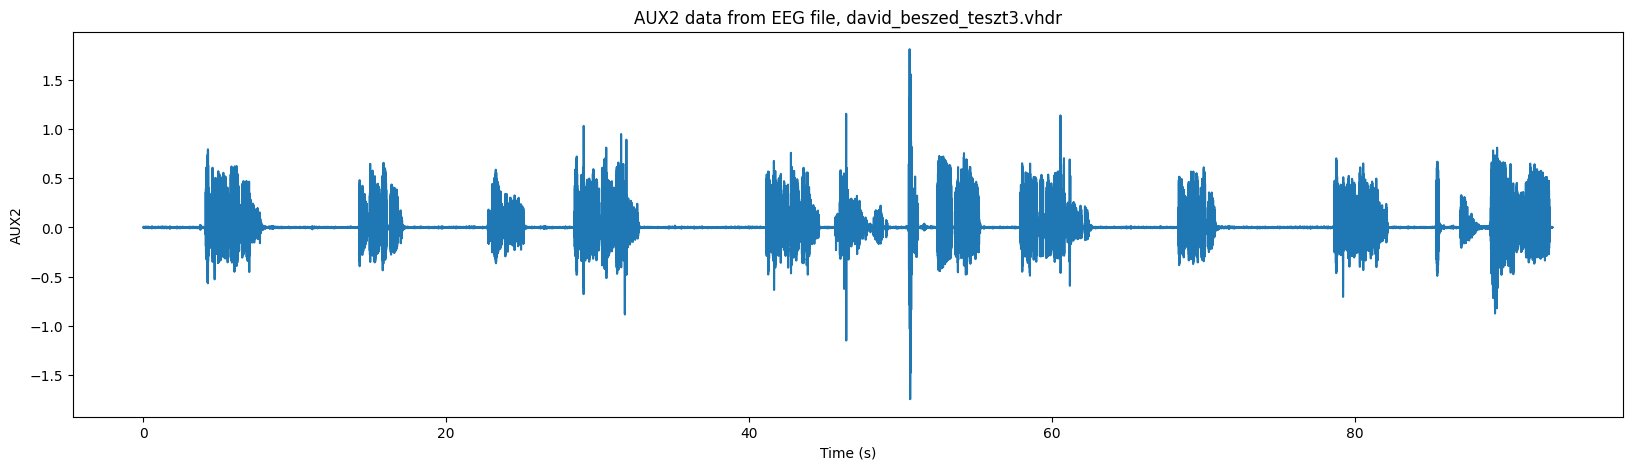

In [8]:
# Step 2: Extract AUX2 channel data
aux_channels = ['AUX2']
aux_data, times = raw_eeg.get_data(picks=aux_channels, return_times=True)
aux_data = aux_data[0]  # Use the AUX2 data

# Plot the AUX2 data
plt.figure(figsize=(20, 5))
plt.plot(times, aux_data)
plt.xlabel('Time (s)')
plt.ylabel('AUX2')
plt.title('AUX2 data from EEG file, ' + eeg_file)
plt.show()

Text(0.5, 1.0, 'Normalized AUX2 data from EEG file, david_beszed_teszt3.vhdr')

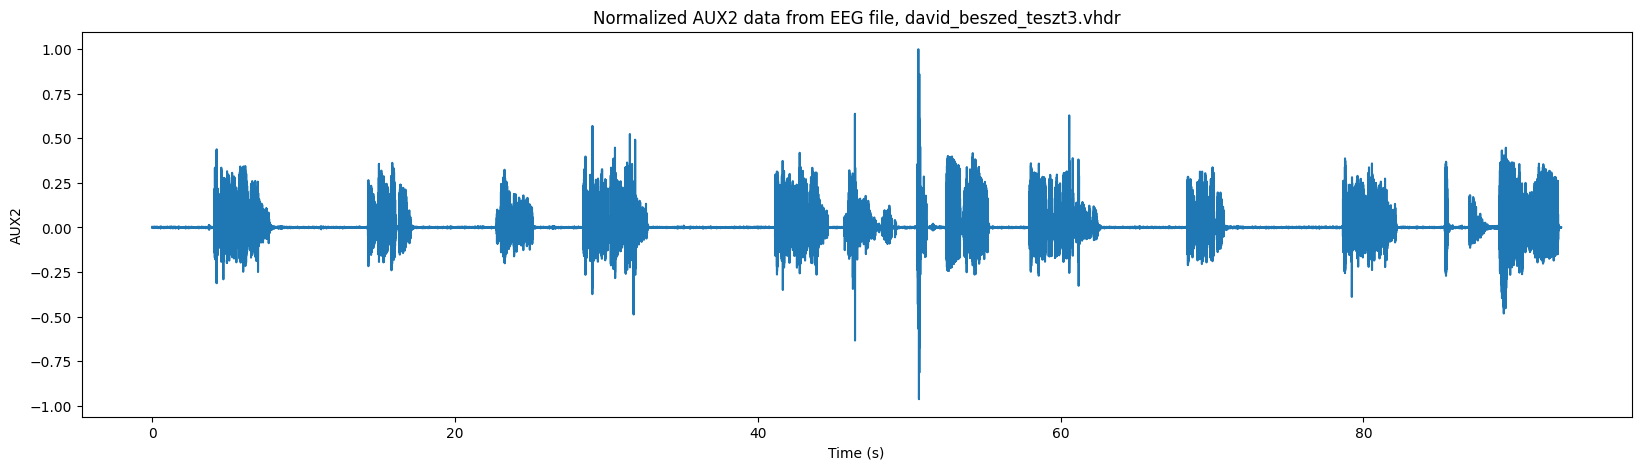

In [9]:
aux_data = normalize_signal(aux_data)  # Normalize AUX2 signal

# Plot the AUX2 data
plt.figure(figsize=(20, 5))
plt.plot(times, aux_data)
plt.xlabel('Time (s)')
plt.ylabel('AUX2')
plt.title('Normalized AUX2 data from EEG file, ' + eeg_file)

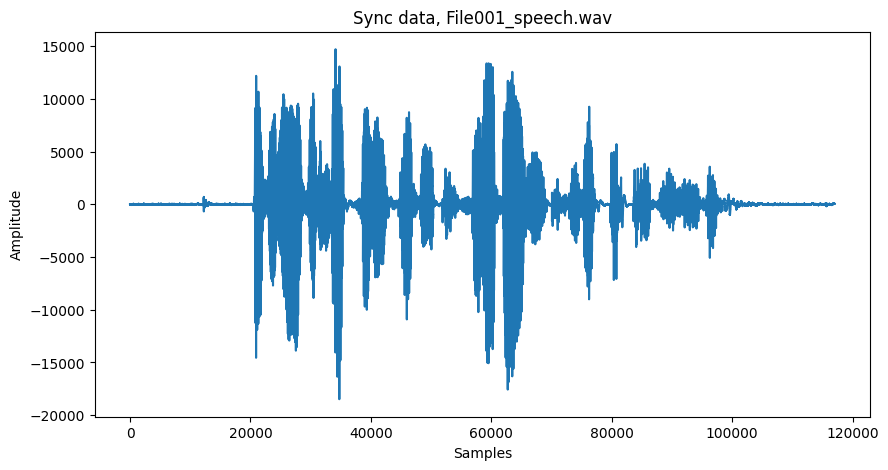

In [10]:
# Step 3: Read sync data from the first sync file
speech_file = speech_files_all[0]
sync_data, Fs_sync = read_wav(os.path.join(uti_path, speech_file))

# Plot the sync data
plt.figure(figsize=(10, 5))
plt.plot(sync_data)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Sync data, ' + speech_file)
plt.show()


In [11]:
# play speech_file
import IPython.display as ipd
ipd.Audio(sync_data, rate=Fs_sync)

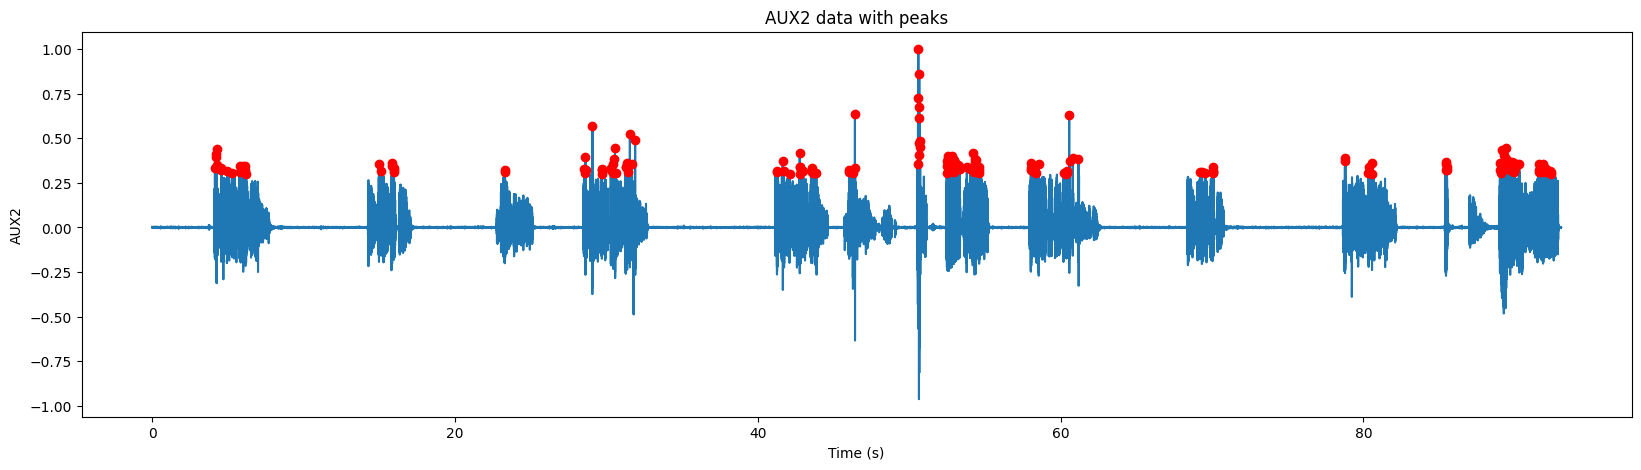

In [12]:
# Plot aux peaks
aux_peaks = detect_peaks_in_signal(aux_data, threshold=0.3, distance=10)
plt.figure(figsize=(20, 5))
plt.plot(times, aux_data)
plt.plot(times[aux_peaks], aux_data[aux_peaks], 'ro')
plt.xlabel('Time (s)')
plt.ylabel('AUX2')
plt.title('AUX2 data with peaks')
plt.show()

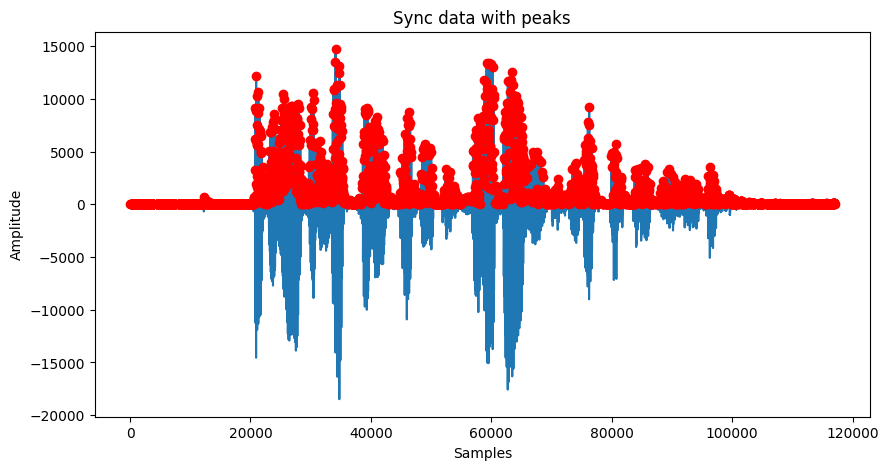

In [13]:
# Plot sync peaks
sync_peaks = detect_peaks_in_signal(sync_data, threshold=0.3, distance=10)
plt.figure(figsize=(10, 5))
plt.plot(sync_data)
plt.plot(sync_peaks, sync_data[sync_peaks], 'ro')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Sync data with peaks')
plt.show()

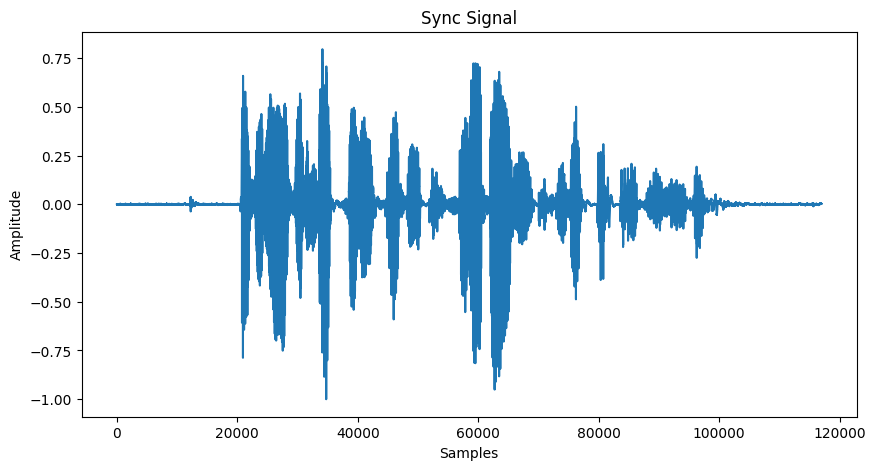

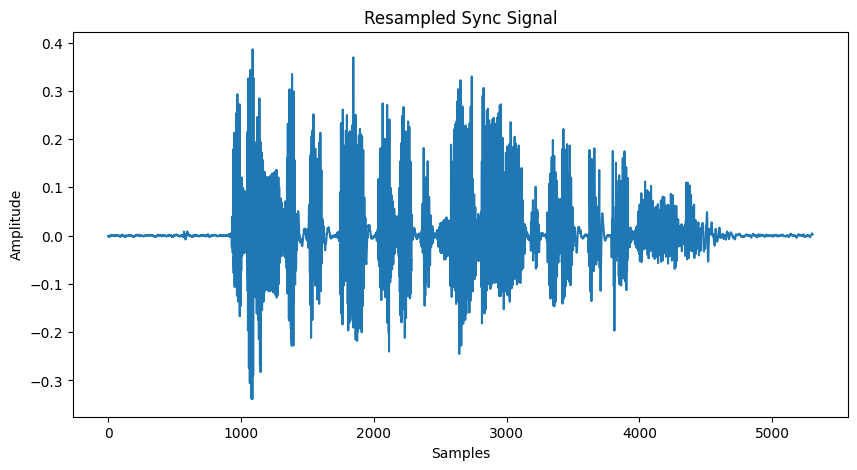

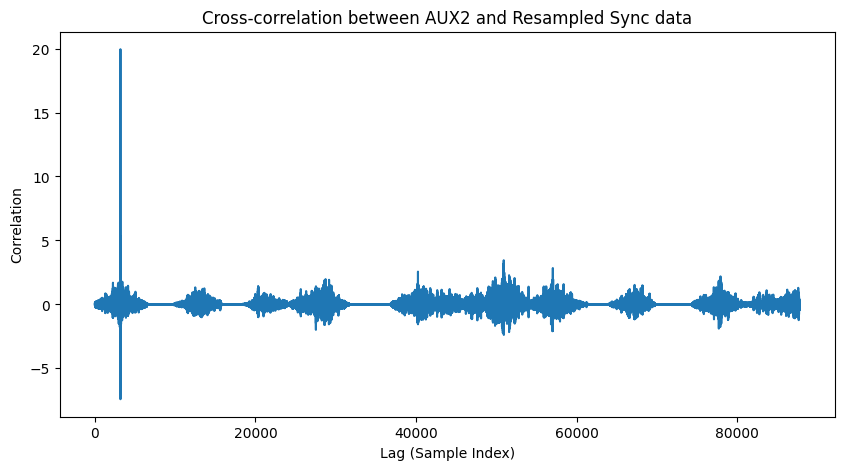

Maximum correlation occurs at lag: 3183 samples


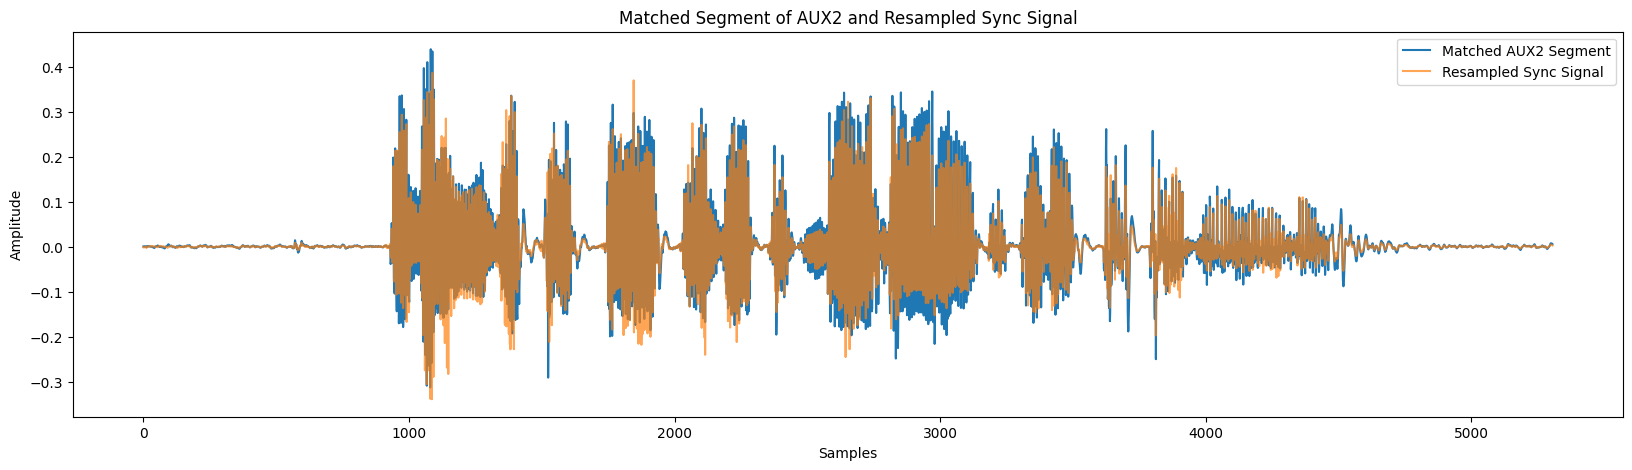

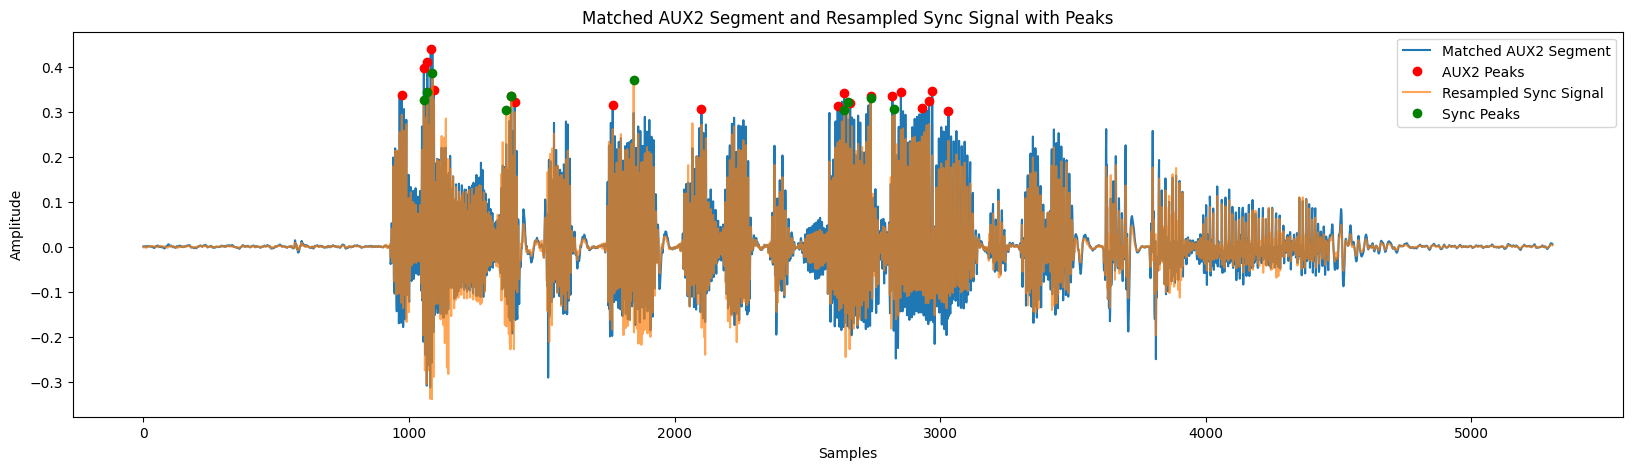

In [14]:


# Step 1: Resample the sync data to match the AUX2 sampling frequency
# Fs_aux is the sampling rate of AUX2, and Fs_sync is the sampling rate of sync
Fs_aux = raw_eeg.info['sfreq']  # AUX2 sampling frequency (from EEG file)

# resample the sync data using soundfile
sync_data, Fs_sync = sf.read(os.path.join(uti_path, speech_file))
sync_data = normalize_signal(sync_data)
sync_resampled = librosa.resample(sync_data, orig_sr=Fs_sync, target_sr=Fs_aux)

# Plot before Resempling
plt.figure(figsize=(10, 5))
plt.plot(sync_data)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Sync Signal')
plt.show()

# Plot the resampled sync data
plt.figure(figsize=(10, 5))
plt.plot(sync_resampled)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Resampled Sync Signal')
plt.show()

# Step 2: Cross-correlate the AUX2 data with the resampled sync data
# The AUX2 signal is long, and the resampled sync data is short.
# We'll slide the sync data over the AUX2 signal to find the best match.
correlation = correlate(aux_data, sync_resampled, mode='valid')
correlation_lags = np.arange(len(aux_data) - len(sync_resampled) + 1)

# Plot the cross-correlation result
plt.figure(figsize=(10, 5))
plt.plot(correlation_lags, correlation)
plt.xlabel('Lag (Sample Index)')
plt.ylabel('Correlation')
plt.title('Cross-correlation between AUX2 and Resampled Sync data')
plt.show()

# Step 3: Find the lag with the maximum correlation
max_corr_index = np.argmax(correlation)
lag_at_max_corr = correlation_lags[max_corr_index]
print(f"Maximum correlation occurs at lag: {lag_at_max_corr} samples")

# Step 4: Extract the corresponding segment from the AUX2 signal
matched_segment_aux = aux_data[lag_at_max_corr: lag_at_max_corr + len(sync_resampled)]

# Plot the matched segment from AUX2 and the resampled sync signal
plt.figure(figsize=(20, 5))
plt.plot(matched_segment_aux, label='Matched AUX2 Segment')
plt.plot(sync_resampled, label='Resampled Sync Signal', alpha=0.7)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Matched Segment of AUX2 and Resampled Sync Signal')
plt.legend()
plt.show()

# Step 5: detect peaks for further comparison
matched_aux_peaks = detect_peaks_in_signal(matched_segment_aux, threshold=0.3, distance=10)
sync_peaks = detect_peaks_in_signal(sync_resampled, threshold=0.3, distance=10)

# Plot peaks for both signals
plt.figure(figsize=(20, 5))
plt.plot(matched_segment_aux, label='Matched AUX2 Segment')
plt.plot(matched_aux_peaks, matched_segment_aux[matched_aux_peaks], 'ro', label='AUX2 Peaks')
plt.plot(sync_resampled, label="Resampled Sync Signal", alpha=0.7)
plt.plot(sync_peaks, sync_resampled[sync_peaks], 'go', label='Sync Peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Matched AUX2 Segment and Resampled Sync Signal with Peaks')
plt.legend()
plt.show()

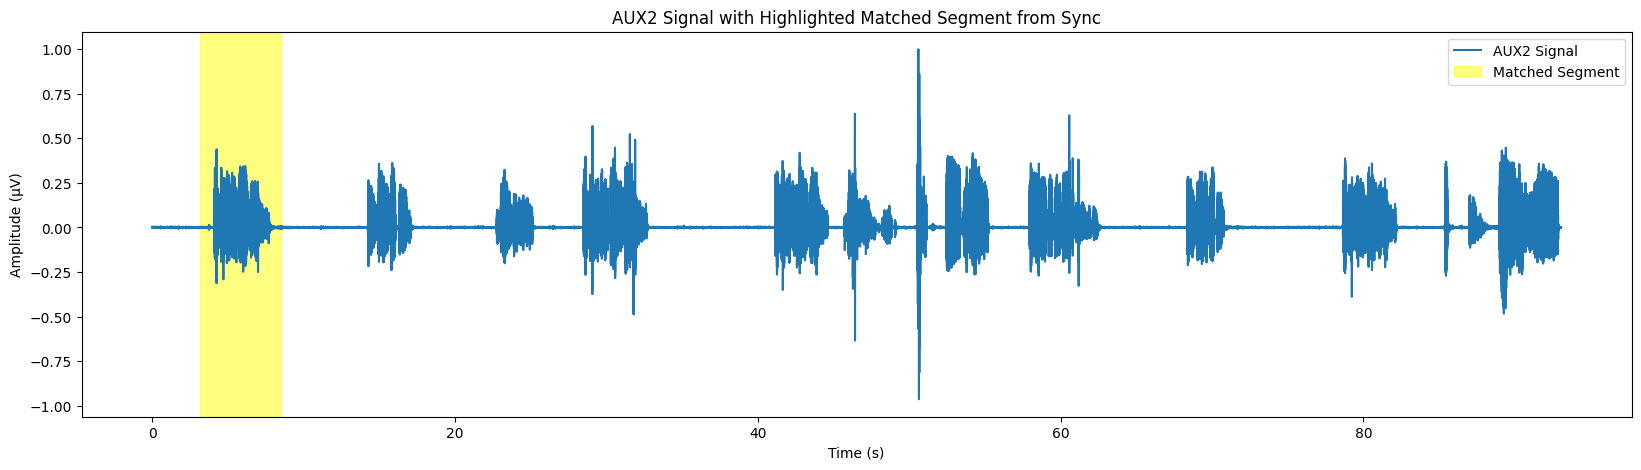

In [15]:
# Plot the original AUX2 signal with the detected segment highlighted

plt.figure(figsize=(20, 5))

# Plot the original AUX2 data
plt.plot(times, aux_data, label='AUX2 Signal')

# Highlight the region where the sync signal was found
# We use the `lag_at_max_corr` to determine the start of the matching segment
start_time = times[lag_at_max_corr]
end_time = times[lag_at_max_corr + len(sync_resampled)]
plt.axvspan(start_time, end_time, color='yellow', alpha=0.5, label='Matched Segment')

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.title('AUX2 Signal with Highlighted Matched Segment from Sync')
plt.legend()
plt.show()

In [16]:
# Calculate the onset time and duration of the matched segment
# `lag_at_max_corr` gives the starting index of the matched segment in AUX2 data

# Onset time (start time) in seconds
onset_time_aux2 = times[lag_at_max_corr]  # Start time in AUX2

# Duration of the matched segment (in seconds)
duration_aux2 = (len(sync_resampled) / Fs_aux)  # Duration is the length of the sync segment divided by AUX2 sampling frequency

# Print the results
print(f"Onset time of matched segment in AUX2: {onset_time_aux2:.4f} seconds")
print(f"Duration of matched segment: {duration_aux2:.4f} seconds")

# End time of the matched segment
end_time_aux2 = onset_time_aux2 + duration_aux2
print(f"End time of matched segment in AUX2: {end_time_aux2:.4f} seconds")

Onset time of matched segment in AUX2: 3.1830 seconds
Duration of matched segment: 5.3060 seconds
End time of matched segment in AUX2: 8.4890 seconds


# Putting it all together

Now that we have the steps to find the matched segment between the sync signal and the AUX2 signal, we can put it all together in a loop to process all sync files.

In [ ]:
import os
import mne
import scipy.io.wavfile as io_wav
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate
import soundfile as sf
import librosa
import pandas as pd
import datetime

# Helper functions
def read_wav(filename):
    """Reads a wav file."""
    (Fs, x) = io_wav.read(filename)
    return (x, Fs)

def normalize_signal(signal):
    """Normalize the signal to be in the range of -1 to 1."""
    return signal / np.max(np.abs(signal))

def detect_peaks_in_signal(signal, threshold=0.3, distance=1000):
    """Detect peaks in a normalized signal using a threshold."""
    peaks, _ = find_peaks(signal, height=threshold, distance=distance)
    return peaks

# Directory paths
dir_data = os.path.join('data', '05_experiment_2024_09_06', 'Sztahó Dávid')
uti_path = os.path.join(dir_data, "UTI", 'Export3')
eeg_path = os.path.join(dir_data, "EEG")

# List EEG and sync files
eeg_files = [f for f in sorted(os.listdir(eeg_path)) if f.endswith('.vhdr')]
speech_files_all = [f for f in sorted(os.listdir(uti_path)) if f.endswith('_speech.wav')]

# Loop over all sync files and find their matches in AUX2 signal, then plot the matched segments

# Store results for onset time and duration of each sync file in AUX2
matched_segments = []

# Step 1: Read the first EEG file
eeg_file = eeg_files[2]
raw_eeg = mne.io.read_raw_brainvision(os.path.join(eeg_path, eeg_file), preload=True)

# Step 2: Extract AUX2 channel data
aux_channels = ['AUX2']
aux_data, times = raw_eeg.get_data(picks=aux_channels, return_times=True)
aux_data = aux_data[0]  # Use the AUX2 data
aux_data = normalize_signal(aux_data)  # Normalize AUX2 signal
Fs_aux = raw_eeg.info['sfreq']  # AUX2 sampling frequency (from EEG file)

# Loop over all sync files
for i, speech_file in enumerate(speech_files_all):
    # Step 1: Read each sync file
    print(f"Processing sync file: {speech_file}")
    try:
    
        # Step 2: Resample the sync data to match the AUX2 sampling frequency
        sync_data, Fs_sync = sf.read(os.path.join(uti_path, speech_file))
        sync_data = normalize_signal(sync_data)  # Normalize the sync signal
        sync_resampled = librosa.resample(sync_data, orig_sr=Fs_sync, target_sr=Fs_aux) # Resample the sync signal to AUX2 frequency
    
        # Step 3: Cross-correlate the AUX2 data with the resampled sync data
        correlation = correlate(aux_data, sync_resampled, mode='valid')
        correlation_lags = np.arange(len(aux_data) - len(sync_resampled) + 1)
    
        # Step 4: Find the lag with the maximum correlation
        max_corr_index = np.argmax(correlation)
        lag_at_max_corr = correlation_lags[max_corr_index]
    
        # Step 5: Calculate the onset time and duration for this sync file in AUX2
        onset_time_aux2 = times[lag_at_max_corr]  # Onset time of the matched segment in AUX2
        duration_aux2 = len(sync_resampled) / Fs_aux  # Duration of the matched segment in AUX2
    
        # Store the result for this sync file
        matched_segments.append({
            'sync_file': speech_file,
            'onset_time': onset_time_aux2,
            'duration': duration_aux2
        })
    
        # Step 6: Plot the original AUX2 signal with the detected segment highlighted
        plt.figure(figsize=(20, 5))
        plt.plot(times, aux_data, label='AUX2 Signal')
    
        # Highlight the region where the sync signal was found
        start_time = times[lag_at_max_corr]
        end_time = start_time + duration_aux2
        plt.axvspan(start_time, end_time, color='yellow', alpha=0.5, label=f'Matched Segment for {speech_file}')
    
        # Add labels and title
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (μV)')
        plt.title(f'AUX2 Signal with Highlighted Matched Segment from {speech_file}')
        plt.legend()
        plt.show()
    
        # Print results for this sync file
        print(f"Sync file: {speech_file}")
        print(f"Onset time of matched segment in AUX2: {onset_time_aux2:.4f} seconds")
        print(f"Duration of matched segment: {duration_aux2:.4f} seconds")
        print(f"End time of matched segment: {onset_time_aux2 + duration_aux2:.4f} seconds")
        print("-" * 50)
    except Exception as e:
        print(f"Error processing file: {speech_file}")
        print(f"Error: {e}")
        print("-" * 50)

matched_segments_df = pd.DataFrame(matched_segments)

# Get the current date and time in UTC timezone, for file naming
now = datetime.datetime.now(datetime.timezone.utc).isoformat().replace(':', '-').replace('.', '_')

# Add EEG file name to the DataFrame
matched_segments_df['eeg_file'] = eeg_file

# Add prompts to the DataFrame
prompts = []
for speech_file in speech_files_all:
    # Read the prompt from the corresponding text file
    prompt_file = speech_file.replace('_speech.wav', '.txt')
    with open(os.path.join(uti_path, prompt_file), 'r', encoding='ISO-8859-1') as f:
        prompt = f.read()
        # get the first line of the prompt
        prompt = prompt.split('\n')[0]
        prompts.append(prompt)
        # add the prompt to the DataFrame, where sync_file matches the speech file
        matched_segments_df.loc[matched_segments_df['sync_file'] == speech_file, 'prompt'] = prompt


# Save the matched segments to a CSV file
file_name = f"matched_segments_{now}.csv"
matched_segments_df.to_csv(file_name, index=False, float_format='%.4f', date_format='%Y-%m-%d %H:%M:%S', sep=';')

# Print the DataFrame
print(matched_segments_df)
print(f"Saved matched segments to: {file_name}")